In [97]:
"""
This code performs graph classification with a simple Graph Convolutional Neural Network based on Spektral
So far graphic cards do not work and it only works on woodycap
"""

import spektral as spektral #package based on Keras that is foundation for GNNs
import tables #show h5 files hirarchy
import h5py
import numpy as np
import keras
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12}) #change font size of diagrams
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #for compatability?
import tensorflow as tf
import multiprocessing #for parall computing
from joblib import Parallel, delayed

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout

#print software versions
from platform import python_version
print("Runnning Jupyter Notebook using python version: {}".format(python_version()))
print("Running tensorflow version: {}".format(tf.keras.__version__))
print("Running tensorflow.keras version: {}".format(tf.__version__))
#print("Running keras version: {}".format(keras.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

"""
tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
"""
"""
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
"""

from spektral.datasets import TUDataset #example dataset (molecules?)
from spektral.layers import GINConv, GlobalAvgPool, GlobalMaxPool, GlobalSumPool,GCNConv, GlobalSumPool, GCSConv
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.data import Dataset, DisjointLoader, Graph, BatchLoader, PackedBatchLoader #Dataset to create a custom dataset
from spektral.transforms.normalize_adj import NormalizeAdj

from ctapipe.visualization import CameraDisplay #for visualisation of hexagonal pixel plots
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.instrument import CameraGeometry #for obtaining adjacency matrix of the camera
from ctapipe.calib import CameraCalibrator

"""
#this code makes Nvidia RTX3080 also compatible with the code
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
"""

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Runnning Jupyter Notebook using python version: 3.8.13
Running tensorflow version: 2.6.0
Running tensorflow.keras version: 2.6.0
Num GPUs Available:  0


/home/hpc/caph/mppi109h/miniconda3/envs/myenv/lib/python3.8/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
channels = 128  # Hidden units
layers = 3  # GIN layers
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

################################################################################
# Load data
################################################################################
dataset = TUDataset("PROTEINS", clean=True)

# Parameters
F = dataset.n_node_features  # Dimension of node features (here it is 4)
n_out = dataset.n_labels  # Dimension of the target (here 2)


print(dataset)
print(type(dataset))
print(dataset[1])



# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)


################################################################################
# Build model
################################################################################
class GIN0(Model):
    def __init__(self, channels, n_layers):
        super().__init__()
        self.conv1 = GINConv(channels, epsilon=0, mlp_hidden=[channels, channels])
        self.convs = []
        for _ in range(1, n_layers):
            self.convs.append(
                GINConv(channels, epsilon=0, mlp_hidden=[channels, channels])
            )
        self.pool = GlobalAvgPool()
        self.dense1 = Dense(channels, activation="relu")
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(n_out, activation="softmax")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a])
        x = self.pool([x, i])
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)


# Build model
model = GIN0(channels, layers)
optimizer = Adam(learning_rate)
loss_fn = CategoricalCrossentropy()


################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
    return loss, acc


epoch = step = 0
results = []
for batch in loader_tr:
    step += 1
    loss, acc = train_step(*batch)
    results.append((loss, acc))
    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1
        print("Ep. {} - Loss: {}. Acc: {}".format(epoch, *np.mean(results, 0)))
        results = []

################################################################################
# Evaluate model
################################################################################
results = []
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    results.append(
        (
            loss_fn(target, predictions),
            tf.reduce_mean(categorical_accuracy(target, predictions)),
        )
    )
print("Done. Test loss: {}. Test acc: {}".format(*np.mean(results, 0)))

In [98]:
#load event data of gammas (and later also protons) (DL1.h5) as h5 data containers

file = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1/gamma_20deg_0deg_run7239___cta-prod5-paranal_desert-2147m-Paranal-dark_cone10_merged.DL1.h5"
file_proton = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_proton_North_20deg_ctapipe_v0.10.5_DL1/proton_20deg_0deg_run4386___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5"

h5file = tables.open_file(file, driver="H5FD_CORE")
protons = tables.open_file(file_proton, driver="H5FD_CORE")

print(h5file)


/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1/gamma_20deg_0deg_run7239___cta-prod5-paranal_desert-2147m-Paranal-dark_cone10_merged.DL1.h5 (File) ''
Last modif.: '2021-11-23T18:51:34+00:00'
Object Tree: 
/ (RootGroup) ''
/configuration (Group) ''
/dl1 (Group) ''
/simulation (Group) ''
/simulation/event (Group) ''
/simulation/service (Group) ''
/simulation/service/shower_distribution (Table(5,)fletcher32, shuffle, blosc:zstd(5)) 'Storage of SimulatedShowerDistribution'
/simulation/event/subarray (Group) ''
/simulation/event/subarray/shower (Table(5436,)fletcher32, shuffle, blosc:zstd(5)) 'Storage of EventIndexContainer,SimulatedShowerContainer'
/simulation/event/telescope (Group) ''
/simulation/event/telescope/images (Group) ''
/simulation/event/telescope/images/tel_001 (Table(394,)fletcher32, shuffle, blosc:zstd(5)) 'Storage of TelEventIndexContainer,SimulatedCameraContainer'
/simulation/event/telescope/im

In [99]:
#print(protons)
print(np.array(protons.root.dl1.event.telescope.images.tel_001.col("image")).shape)

(194, 1855)


In [100]:
#overview of the loaded h5 data and a few subfolders

#command: shows subgroup names: ._g_getnchildren
#command: print(h5file.root.dl1.event.telescope.images._f_iter_nodes) iterate over all nodes=subtables in the group
print(h5file.root.dl1.event.telescope.images.tel_001)
print(h5file.root.dl1.event.telescope.images.tel_001.description)
print(h5file.root.dl1.event.telescope.images.tel_001.cols)
print(h5file.root.dl1.event.telescope.images.tel_001.nrows)
print(np.array(h5file.root.dl1.event.telescope.images.tel_001.col("image")).shape)
print(np.array(h5file.root.dl1.event.telescope.parameters.tel_001.description))
print(np.array(h5file.root.dl1.event.telescope.parameters.tel_001.col("hillas_intensity")).shape) #show one hillas

print("\n")

#this seems to be DL2 data format (whatever that means), these are not the relevant training images
print(h5file.root.simulation.event.telescope.images.tel_001)
print(h5file.root.simulation.event.telescope.images.tel_001.description)
print(h5file.root.simulation.event.telescope.images.tel_001.cols)
print(h5file.root.simulation.event.telescope.images.tel_001.nrows)
print(np.array(h5file.root.simulation.event.telescope.images.tel_001.col("true_image")).shape)

#show geometry of the cams (all of them at the end of print(h5file))
print("\n")
print(h5file.root.configuration.instrument.telescope.camera.geometry_LSTCam.description)
print(h5file.root.configuration.instrument.telescope.camera.geometry_LSTCam.nrows)


/dl1/event/telescope/images/tel_001 (Table(394,)fletcher32, shuffle, blosc:zstd(5)) 'Storage of TelEventIndexContainer,DL1CameraContainer'
Description([('obs_id', '()i4'), ('event_id', '()i8'), ('tel_id', '()i2'), ('image', '(1855,)i4'), ('peak_time', '(1855,)i2'), ('image_mask', '(1855,)b1')])
/dl1/event/telescope/images/tel_001.cols (Cols), 6 columns
394
(394, 1855)
Description([('obs_id', '()i4'), ('event_id', '()i8'), ('tel_id', '()i2'), ('hillas_intensity', '()f8'), ('hillas_x', '()f8'), ('hillas_y', '()f8'), ('hillas_r', '()f8'), ('hillas_phi', '()f8'), ('hillas_length', '()f8'), ('hillas_length_uncertainty', '()f8'), ('hillas_width', '()f8'), ('hillas_width_uncertainty', '()f8'), ('hillas_psi', '()f8'), ('hillas_skewness', '()f8'), ('hillas_kurtosis', '()f8'), ('timing_slope', '()f8'), ('timing_intercept', '()f8'), ('timing_deviation', '()f8'), ('leakage_pixels_width_1', '()f8'), ('leakage_pixels_width_2', '()f8'), ('leakage_intensity_width_1', '()f4'), ('leakage_intensity_width

[[False  True False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False  True  True]
 [False False False ...  True False False]
 [False False False ...  True False False]]


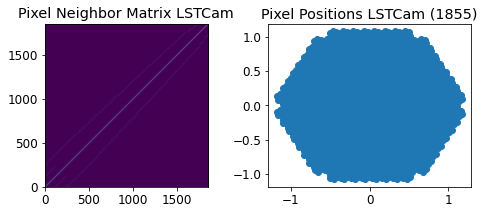

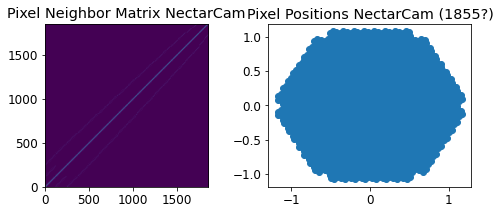

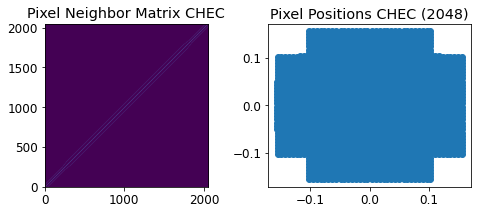

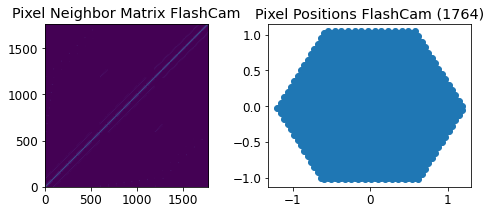

In [101]:
#plot adjacency matrix of given geometry in input file using ctapipe
geom = CameraGeometry.from_name("LSTCam") #geometry of LST camera

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower") #geom.neighbor_matrix is the adjacency matrix
plt.title("Pixel Neighbor Matrix LSTCam") #adjacency matrix for LST camera

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions LSTCam (1855)")


geom = CameraGeometry.from_name("NectarCam") #geometry that looks like LST camera

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower")
plt.title("Pixel Neighbor Matrix NectarCam")

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions NectarCam (1855?)")



geom = CameraGeometry.from_name("CHEC") #???

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower")
plt.title("Pixel Neighbor Matrix CHEC")

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions CHEC (2048)")


geom = CameraGeometry.from_name("FlashCam") #???

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower")
plt.title("Pixel Neighbor Matrix FlashCam")

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions FlashCam (1764)")

print(geom.neighbor_matrix) #adjacency matrix for one camera

In [102]:
#this path is DL1 data
#collect gamma images from all telescope types and putting it to a list called images
tel = h5file.root.dl1.event.telescope.images._f_iter_nodes()
images = []
for tel in tel:
    images.append(tel.col("image"))

print(len(images))
#print(images) #images contains ~180 telescope folders (LST, FlashCam,...) with few hundred images each

#collect for every tel_x hillas intensity for gammas
tel = h5file.root.dl1.event.telescope.parameters._f_iter_nodes()
hillas_gamma = []
for tel in tel:
    hillas_gamma.append(tel.col("hillas_intensity"))

print(len(hillas_gamma))





#collect proton images from all telescope types and putting it to a list called images_proton
tel_proton = protons.root.dl1.event.telescope.images._f_iter_nodes()
images_proton = []
for tel_proton in tel_proton:
    images_proton.append(tel_proton.col("image"))

#print(images_proton) #images contains ~180 telescope folders (LST, FlashCam,...) with few hundred images each
print(len(images_proton)) #also 180 events

#collect for every tel_x hillas intensity for protons
tel = protons.root.dl1.event.telescope.parameters._f_iter_nodes()
hillas_proton = []
for tel in tel:
    hillas_proton.append(tel.col("hillas_intensity"))

print(len(hillas_proton))

180
180
180
180


'this codeblock is redundant if one only wants LST images with 1855 pixels'
#not useful so far, because then one also gets geometries of other cameras

print(np.array(images[7]).shape) #one element meaning one telescope camera type (for example LST, FlashCam,...) has this shape
print(np.array(images[7])[11,:]) #list of pixel values (in photoelectrons?) of one specific image 11 from one specific telescope camera 7


#collect geometries for all 180 entries of telescope camera types (for example LST, FlashCam,...)
geometries = []

#collect adjacency matrix for every telescope camera depending on the number of pixels of the camera
for i in range(len(images)):
    if np.ma.size(np.array(images[i]), axis = 1) == 1855:
        geometries.append(CameraGeometry.from_name("LSTCam").neighbor_matrix)
    elif np.ma.size(np.array(images[i]), axis = 1) == 2048:
        geometries.append(CameraGeometry.from_name("CHEC").neighbor_matrix)
    elif np.ma.size(np.array(images[i]), axis = 1) == 1764:
        geometries.append(CameraGeometry.from_name("FlashCam").neighbor_matrix)
    else:
        Print("Something went wrong")


print(len(geometries))
print(geometries[1]) #adjacency matrix of telescope camera [1]

#now we have images (180 tel with a few hundred images each)
# and also geometries with 180 ajacency matrices

In [103]:
#select only LST gamma images (or at least images with 1855 pixels (do not know the difference so far)) and save them in images_lst
images_lst_list = []
hillas_intensity_gamma = []

for i in range(len(images)):
    if np.ma.size(np.array(images[i]), axis = 1) == 1855:
        images_lst_list.append(images[i])
        hillas_intensity_gamma.append(hillas_gamma[i])
    else:
        pass
    
images_lst = np.empty((0,1855))
for i in range(len(images_lst_list)):
    images_lst = np.concatenate((images_lst, np.array(images_lst_list[i])), axis = 0)


print(images_lst)
print("Now gamma image shape is:", images_lst.shape)

#flattens/concatenates all hillas intensities in tel_x files
hillas_intensity_gamma = np.concatenate(hillas_intensity_gamma).ravel()
print("Gamma hillas entries:", len(hillas_intensity_gamma))





#select only LST proton images (or at least images with 1855 pixels (do not know the difference so far)) and save tem in images_lst_proton
images_lst_proton_list = []
hillas_intensity_proton = []

for i in range(len(images_proton)):
    if np.ma.size(np.array(images_proton[i]), axis = 1) == 1855:
        images_lst_proton_list.append(images_proton[i])
        hillas_intensity_proton.append(hillas_proton[i])
    else:
        pass
    
images_lst_proton = np.empty((0,1855))
for i in range(len(images_lst_proton_list)):
    images_lst_proton = np.concatenate((images_lst_proton, np.array(images_lst_proton_list[i])), axis = 0)

print("Now proton image shape is:", images_lst_proton.shape)

#flattens/concatenates all hillas intensities in tel_x files
hillas_intensity_proton = np.concatenate(hillas_intensity_proton).ravel()
print("Proton hillas entries:", len(hillas_intensity_proton))


#collect LST geometry
geometrie_lst = CameraGeometry.from_name("LSTCam").neighbor_matrix #this collects LST adjacency matrix
geometrie_lst = geometrie_lst.astype(np.float32) #convert from bool to float for GNN input
#spektral.transforms.normalize_adj.NormalizeAdj(symmetric=True)

print("Now adjacency shape is:", geometrie_lst.shape)
#print("\n", geometrie_lst)






# Select for hillas_intensity > X using a threshold for gammas and protons
threshold = 0

#select gamma events > threshold
mask_hillas_gamma = hillas_intensity_gamma > threshold
images_lst = images_lst[mask_hillas_gamma]
print(len(images_lst))

#select proton events > threshold
mask_hillas_proton = hillas_intensity_proton > threshold
images_lst_proton = images_lst_proton[mask_hillas_proton]
print(images_lst_proton[1])


[[ 13.   2.   5. ...  -6.  26.  14.]
 [ -1.  -1.   8. ...   1. -19.   6.]
 [ -3.   3.   4. ...  -5. -15. -14.]
 ...
 [ 19.   9.   0. ...  -4.   3.   2.]
 [  3.  -4.  -5. ...  -3. -14.  -3.]
 [ 10.  -2.  34. ...   2.  -7.   2.]]
Now gamma image shape is: (12622, 1855)
Gamma hillas entries: 12622
Now proton image shape is: (6701, 1855)
Proton hillas entries: 6701
Now adjacency shape is: (1855, 1855)
11722
[-10.   7.   1. ... -13.  16.   2.]


[ -4 -15  -1 ...   0  10 -21]


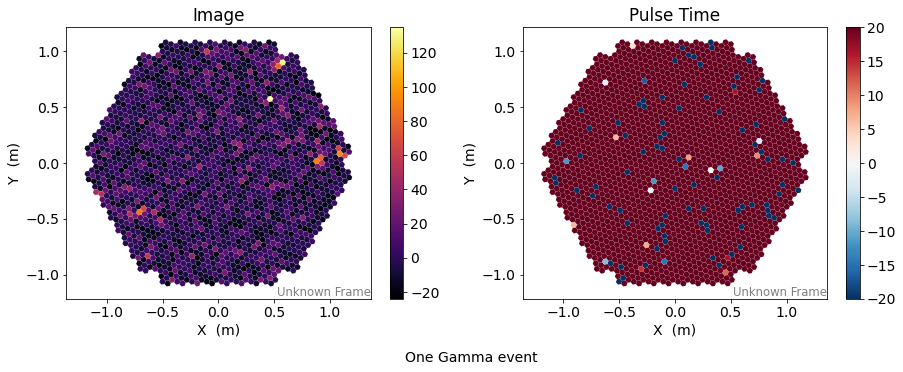

In [104]:
#plot examplex of gamma events WITH THRESHOLD here


#define global figuresize
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize']

print(h5file.root.dl1.event.telescope.images.tel_001.col("image")[5]) #list of pixel values for specific gamma event


i = 1 #select specific image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
txt="One Gamma event"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center')

d1 = CameraDisplay(CameraGeometry.from_name("LSTCam"), ax=ax1)
d2 = CameraDisplay(CameraGeometry.from_name("LSTCam"), ax=ax2)

ax1.set_title('Image')
d1.image = images_lst[i]
d1.add_colorbar(ax=ax1)

ax2.set_title('Pulse Time')
d2.image = h5file.root.dl1.event.telescope.images.tel_001.col("peak_time")[i] - np.average(h5file.root.dl1.event.telescope.images.tel_001.col("peak_time")[i], weights=h5file.root.dl1.event.telescope.images.tel_001.col("image")[i])
d2.cmap = 'RdBu_r'
d2.add_colorbar(ax=ax2)
d2.set_limits_minmax(-20,20)

In [105]:
#test loop over tel:
"""testfile = str(h5file.root.dl1.event.telescope.images.tel_) + str(i) +str(col("image")[5])
print(testfile)
for i in range(5):
    print()
    
"""

'testfile = str(h5file.root.dl1.event.telescope.images.tel_) + str(i) +str(col("image")[5])\nprint(testfile)\nfor i in range(5):\n    print()\n    \n'

[ -4 -15  -1 ...   0  10 -21]


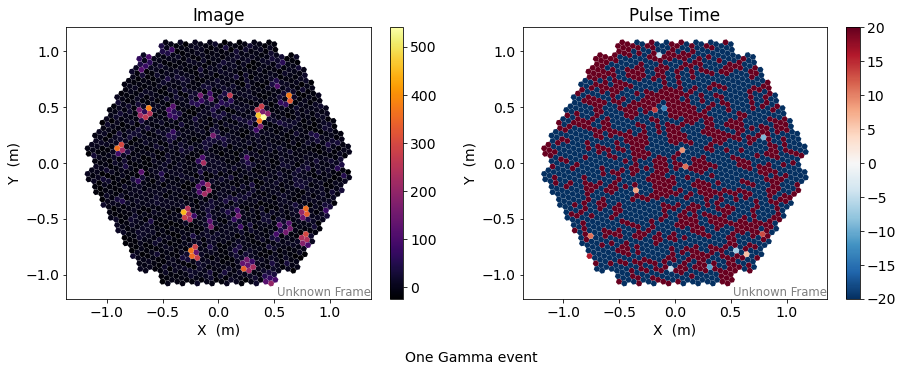

In [106]:
#plot examplex of gamma events here


#define global figuresize
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize']

print(h5file.root.dl1.event.telescope.images.tel_001.col("image")[5]) #list of pixel values for specific gamma event


i = 35 #select specific image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
txt="One Gamma event"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center')

d1 = CameraDisplay(CameraGeometry.from_name("LSTCam"), ax=ax1)
d2 = CameraDisplay(CameraGeometry.from_name("LSTCam"), ax=ax2)

ax1.set_title('Image')
d1.image = h5file.root.dl1.event.telescope.images.tel_001.col("image")[i]
d1.add_colorbar(ax=ax1)

ax2.set_title('Pulse Time')
d2.image = h5file.root.dl1.event.telescope.images.tel_001.col("peak_time")[i] - np.average(h5file.root.dl1.event.telescope.images.tel_001.col("peak_time")[i], weights=h5file.root.dl1.event.telescope.images.tel_001.col("image")[i])
d2.cmap = 'RdBu_r'
d2.add_colorbar(ax=ax2)
d2.set_limits_minmax(-20,20)

#d1.highlight_pixels(clean, color='red', linewidth=1) #this can highlight cleaned pixels (no cleaning implemented so far)

[27 -3  0 ... -4 -4  6]


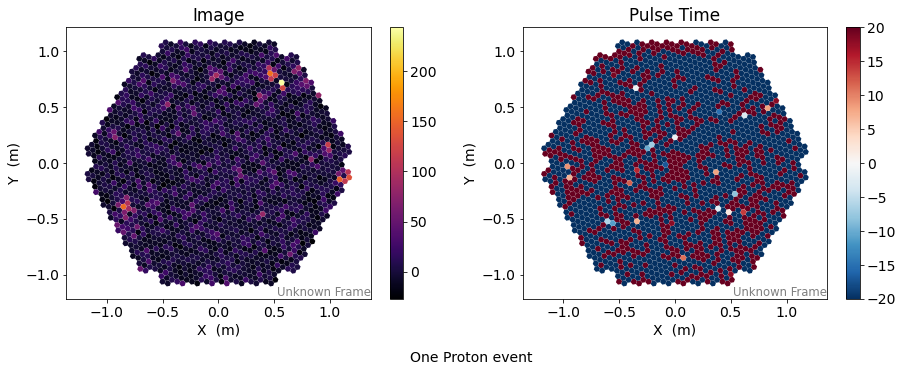

In [107]:
#plot examplex of proton events here


#define global figuresize
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize']

print(protons.root.dl1.event.telescope.images.tel_001.col("image")[5]) #list of pixel values for specific proton event


i = 35 #select specific image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
txt="One Proton event"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center')


d1 = CameraDisplay(CameraGeometry.from_name("LSTCam"), ax=ax1)
d2 = CameraDisplay(CameraGeometry.from_name("LSTCam"), ax=ax2)

ax1.set_title('Image')
d1.image = protons.root.dl1.event.telescope.images.tel_001.col("image")[i]
d1.add_colorbar(ax=ax1)

ax2.set_title('Pulse Time')
d2.image = protons.root.dl1.event.telescope.images.tel_001.col("peak_time")[i] - np.average(h5file.root.dl1.event.telescope.images.tel_001.col("peak_time")[i], weights=h5file.root.dl1.event.telescope.images.tel_001.col("image")[i])
d2.cmap = 'RdBu_r'
d2.add_colorbar(ax=ax2)
d2.set_limits_minmax(-20,20)

In [108]:
#prepare gamma labels for each graph (meaning each image)
labels = np.ones(np.size(images_lst, 0))
print(labels.shape) #x times number one as the target value

#prepare proton labels for each graph (meaning each image)
labels_proton = np.zeros(np.size(images_lst_proton, 0))
print(labels_proton.shape) #y times number one as the target value

(11722,)
(6152,)


In [109]:
#merging proton and gamma images and labels
labels = np.concatenate((labels,labels_proton))
images_lst = np.concatenate((images_lst, images_lst_proton))
print(labels.shape)
print(images_lst.shape)


(17874,)
(17874, 1855)


In [110]:
# spektral custom dataset class so one transforms numpy arrays to Spektral datasets (for GNN input)
class MyDataset(Dataset): #in brackets one puts inherited classes
    """
    A dataset created by a numpy array of images of shape (number_of_images, number_of_pixels) and
    by a numpy array of labels of shape (number_of_images)
    """
    def __init__(self, images, labels, **kwargs): #initiate instance
        self.images = images
        self.labels = labels
        super().__init__(**kwargs) #inherit from other classes
        
    def read(self): #this function returns a list of graph objects so that Spektral takes it as the GNNs input
        # We must return a list of Graph objects
        output = []

        for i in range(np.size(self.labels)): #do for all training images
            output.append(spektral.data.graph.Graph(x = self.images[i,:], a = geometrie_lst, y = self.labels[i]))

        return output

#create a new instance from the class Dataset
dataset = MyDataset(images_lst[:,:], labels[:]) #, transforms=NormalizeAdj() #this takes a lot of ram
input_gnn = dataset.read() #write down a list of graph objects calling a class method of the instance

print(dataset) #this only gives position in RAM space
print(type(dataset))
print(dataset[3])
print()

print(input_gnn[10:13])
print(type(input_gnn))
print(input_gnn[4])
print(len(input_gnn))

MyDataset(n_graphs=17874)
<class '__main__.MyDataset'>
Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1)

[Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1), Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1), Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1)]
<class 'list'>
Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1)
17874


/home/hpc/caph/mppi109h/miniconda3/envs/myenv/lib/python3.8/site-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (1855, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")


In [111]:
#training parameters
batch_size = 32
epochs = 200
opt = "adam"
metrics = tf.keras.metrics.AUC(from_logits=True)
VALIDATION_SPLIT = 0.1

# Train/valid/test split
print("Images (tr+va+te):", len(dataset))
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = dataset[idx_tr]
data_va = dataset[idx_va]
data_te = dataset[idx_te]

# Data loaders
#loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs, node_level=True) # for disjoint loader
loader_tr = BatchLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = BatchLoader(data_va, batch_size=batch_size)
loader_te = BatchLoader(data_te, batch_size=batch_size)

Images (tr+va+te): 17874


In [112]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        self.conv3 = GCSConv(32, activation="relu")
        self.global_pool = GlobalAvgPool() #global sum pool increases loss drastically, use average pool instead
        self.dense = Dense(data_tr.n_labels, activation="sigmoid")

    def call(self, inputs):
        #x, a, i = inputs #for disjoint loader
        x, a = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        #output = self.global_pool([x,i]) #for disjoint loader
        output = self.global_pool(x) #for batch loader
        output = self.dense(output)

        return output
    

In [113]:
#define strategy for splitting training over multiple GPUs #does not work currently
strategy = tf.distribute.MirroredStrategy(devices=None) #devices=None automatically detects all devices
print('Number of devices: {}'.format(strategy.num_replicas_in_sync)) #show number of devices for training


# Wrap data in Dataset objects.
#train_data = tf.data.Dataset.from_tensor_slices(loader_tr.load())

# The batch size must now be set on the Dataset objects.
#batch_size = 32
#train_data = train_data.batch(batch_size)


# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
#train_data = train_data.with_options(options)






INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [114]:
#compile model


model = Net() #first number = number of channels #original was 32
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(from_logits=True)])

with strategy.scope():
    model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs, validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
)



2022-06-28 18:43:20.235695: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_31645"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  v

Epoch 1/200
447/447 [==============================] - ETA: 0s - loss: 7.1229 - auc_3: 0.5069

2022-06-28 18:50:38.189241: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_34205"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  v

447/447 [==============================] - 492s 1s/step - loss: 7.1229 - auc_3: 0.5069 - val_loss: 1.2604 - val_auc_3: 0.5028
Epoch 2/200
447/447 [==============================] - ETA: 0s - loss: 2.1773 - auc_3: 0.5152

2022-06-28 18:58:39.687666: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 2.1773 - auc_3: 0.5152 - val_loss: 3.9349 - val_auc_3: 0.4962
Epoch 3/200
447/447 [==============================] - ETA: 0s - loss: 2.6966 - auc_3: 0.5138

2022-06-28 19:06:47.401490: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 488s 1s/step - loss: 2.6966 - auc_3: 0.5138 - val_loss: 6.1250 - val_auc_3: 0.5000
Epoch 4/200
447/447 [==============================] - ETA: 0s - loss: 1.1928 - auc_3: 0.5192

2022-06-28 19:14:49.277659: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 481s 1s/step - loss: 1.1928 - auc_3: 0.5192 - val_loss: 0.6972 - val_auc_3: 0.5600
Epoch 5/200
447/447 [==============================] - ETA: 0s - loss: 0.8369 - auc_3: 0.5170

2022-06-28 19:22:50.876224: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.8369 - auc_3: 0.5170 - val_loss: 1.9593 - val_auc_3: 0.4588
Epoch 6/200
447/447 [==============================] - ETA: 0s - loss: 0.7686 - auc_3: 0.5207

2022-06-28 19:30:54.555723: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.7686 - auc_3: 0.5207 - val_loss: 0.7091 - val_auc_3: 0.5675
Epoch 7/200
447/447 [==============================] - ETA: 0s - loss: 0.7021 - auc_3: 0.5421

2022-06-28 19:38:57.137177: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.7021 - auc_3: 0.5421 - val_loss: 0.9220 - val_auc_3: 0.4782
Epoch 8/200
447/447 [==============================] - ETA: 0s - loss: 0.6691 - auc_3: 0.5327

2022-06-28 19:47:05.235942: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6691 - auc_3: 0.5327 - val_loss: 0.7171 - val_auc_3: 0.5566
Epoch 9/200
447/447 [==============================] - ETA: 0s - loss: 0.6518 - auc_3: 0.5616

2022-06-28 19:55:14.307443: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 491s 1s/step - loss: 0.6518 - auc_3: 0.5616 - val_loss: 0.6633 - val_auc_3: 0.5605
Epoch 10/200
447/447 [==============================] - ETA: 0s - loss: 0.6822 - auc_3: 0.5395

2022-06-28 20:03:32.243136: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6822 - auc_3: 0.5395 - val_loss: 0.6727 - val_auc_3: 0.5770
Epoch 11/200
447/447 [==============================] - ETA: 0s - loss: 0.6733 - auc_3: 0.5319

2022-06-28 20:11:48.864321: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 498s 1s/step - loss: 0.6733 - auc_3: 0.5319 - val_loss: 0.6659 - val_auc_3: 0.5550
Epoch 12/200
447/447 [==============================] - ETA: 0s - loss: 0.6424 - auc_3: 0.5495

2022-06-28 20:20:10.793626: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6424 - auc_3: 0.5495 - val_loss: 0.6290 - val_auc_3: 0.5921
Epoch 13/200
447/447 [==============================] - ETA: 0s - loss: 0.6411 - auc_3: 0.5551

2022-06-28 20:28:22.335882: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 493s 1s/step - loss: 0.6411 - auc_3: 0.5551 - val_loss: 0.6470 - val_auc_3: 0.5608
Epoch 14/200
447/447 [==============================] - ETA: 0s - loss: 0.6417 - auc_3: 0.5465

2022-06-28 20:36:45.063549: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 502s 1s/step - loss: 0.6417 - auc_3: 0.5465 - val_loss: 0.6724 - val_auc_3: 0.5446
Epoch 15/200
447/447 [==============================] - ETA: 0s - loss: 0.6401 - auc_3: 0.5600

2022-06-28 20:44:59.071721: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6401 - auc_3: 0.5600 - val_loss: 0.6419 - val_auc_3: 0.5684
Epoch 16/200
447/447 [==============================] - ETA: 0s - loss: 0.6383 - auc_3: 0.5564

2022-06-28 20:53:02.667734: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6383 - auc_3: 0.5564 - val_loss: 0.6398 - val_auc_3: 0.5759
Epoch 17/200
447/447 [==============================] - ETA: 0s - loss: 0.6378 - auc_3: 0.5531

2022-06-28 21:01:29.777681: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 533s 1s/step - loss: 0.6378 - auc_3: 0.5531 - val_loss: 0.6367 - val_auc_3: 0.6013
Epoch 18/200
447/447 [==============================] - ETA: 0s - loss: 0.6369 - auc_3: 0.5562

2022-06-28 21:10:31.045627: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 518s 1s/step - loss: 0.6369 - auc_3: 0.5562 - val_loss: 0.6413 - val_auc_3: 0.5700
Epoch 19/200
447/447 [==============================] - ETA: 0s - loss: 0.6383 - auc_3: 0.5482

2022-06-28 21:18:52.829919: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6383 - auc_3: 0.5482 - val_loss: 0.6513 - val_auc_3: 0.5823
Epoch 20/200
447/447 [==============================] - ETA: 0s - loss: 0.6366 - auc_3: 0.5585

2022-06-28 21:27:02.314871: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 517s 1s/step - loss: 0.6366 - auc_3: 0.5585 - val_loss: 0.6511 - val_auc_3: 0.5862
Epoch 21/200
447/447 [==============================] - ETA: 0s - loss: 0.6372 - auc_3: 0.5540

2022-06-28 21:35:36.737760: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6372 - auc_3: 0.5540 - val_loss: 0.6334 - val_auc_3: 0.6088
Epoch 22/200
447/447 [==============================] - ETA: 0s - loss: 0.6367 - auc_3: 0.5579

2022-06-28 21:43:51.947924: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6367 - auc_3: 0.5579 - val_loss: 0.6431 - val_auc_3: 0.5812
Epoch 23/200
447/447 [==============================] - ETA: 0s - loss: 0.6362 - auc_3: 0.5590

2022-06-28 21:52:02.443861: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 490s 1s/step - loss: 0.6362 - auc_3: 0.5590 - val_loss: 0.6488 - val_auc_3: 0.5829
Epoch 24/200
447/447 [==============================] - ETA: 0s - loss: 0.6389 - auc_3: 0.5480

2022-06-28 22:00:07.996301: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 488s 1s/step - loss: 0.6389 - auc_3: 0.5480 - val_loss: 0.6313 - val_auc_3: 0.5986
Epoch 25/200
447/447 [==============================] - ETA: 0s - loss: 0.6361 - auc_3: 0.5543

2022-06-28 22:08:18.949521: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6361 - auc_3: 0.5543 - val_loss: 0.6417 - val_auc_3: 0.5780
Epoch 26/200
447/447 [==============================] - ETA: 0s - loss: 0.6360 - auc_3: 0.5572

2022-06-28 22:16:40.076442: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 532s 1s/step - loss: 0.6360 - auc_3: 0.5572 - val_loss: 0.6311 - val_auc_3: 0.5926
Epoch 27/200
447/447 [==============================] - ETA: 0s - loss: 0.6364 - auc_3: 0.5548

2022-06-28 22:25:26.145231: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 495s 1s/step - loss: 0.6364 - auc_3: 0.5548 - val_loss: 0.6447 - val_auc_3: 0.5829
Epoch 28/200
447/447 [==============================] - ETA: 0s - loss: 0.6366 - auc_3: 0.5524

2022-06-28 22:33:42.969681: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 525s 1s/step - loss: 0.6366 - auc_3: 0.5524 - val_loss: 0.6324 - val_auc_3: 0.5746
Epoch 29/200
447/447 [==============================] - ETA: 0s - loss: 0.6358 - auc_3: 0.5585

2022-06-28 22:42:19.485339: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6358 - auc_3: 0.5585 - val_loss: 0.6398 - val_auc_3: 0.5758
Epoch 30/200
447/447 [==============================] - ETA: 0s - loss: 0.6343 - auc_3: 0.5607

2022-06-28 22:50:23.141337: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6343 - auc_3: 0.5607 - val_loss: 0.6489 - val_auc_3: 0.5777
Epoch 31/200
447/447 [==============================] - ETA: 0s - loss: 0.6357 - auc_3: 0.5594

2022-06-28 22:58:25.742625: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 512s 1s/step - loss: 0.6357 - auc_3: 0.5594 - val_loss: 0.6277 - val_auc_3: 0.6021
Epoch 32/200
447/447 [==============================] - ETA: 0s - loss: 0.6345 - auc_3: 0.5631

2022-06-28 23:06:53.586244: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 508s 1s/step - loss: 0.6345 - auc_3: 0.5631 - val_loss: 0.6352 - val_auc_3: 0.5875
Epoch 33/200
447/447 [==============================] - ETA: 0s - loss: 0.6345 - auc_3: 0.5592

2022-06-28 23:15:21.022850: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 480s 1s/step - loss: 0.6345 - auc_3: 0.5592 - val_loss: 0.6308 - val_auc_3: 0.5782
Epoch 34/200
447/447 [==============================] - ETA: 0s - loss: 0.6346 - auc_3: 0.5626

2022-06-28 23:23:21.608059: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 509s 1s/step - loss: 0.6346 - auc_3: 0.5626 - val_loss: 0.6467 - val_auc_3: 0.5822
Epoch 35/200
447/447 [==============================] - ETA: 0s - loss: 0.6348 - auc_3: 0.5609

2022-06-28 23:32:04.032410: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 494s 1s/step - loss: 0.6348 - auc_3: 0.5609 - val_loss: 0.6385 - val_auc_3: 0.5823
Epoch 36/200
447/447 [==============================] - ETA: 0s - loss: 0.6321 - auc_3: 0.5674

2022-06-28 23:40:27.933073: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 531s 1s/step - loss: 0.6321 - auc_3: 0.5674 - val_loss: 0.6365 - val_auc_3: 0.5802
Epoch 37/200
447/447 [==============================] - ETA: 0s - loss: 0.6334 - auc_3: 0.5620

2022-06-28 23:49:01.225893: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 488s 1s/step - loss: 0.6334 - auc_3: 0.5620 - val_loss: 0.6383 - val_auc_3: 0.5940
Epoch 38/200
447/447 [==============================] - ETA: 0s - loss: 0.6332 - auc_3: 0.5656

2022-06-28 23:57:20.216826: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 586s 1s/step - loss: 0.6332 - auc_3: 0.5656 - val_loss: 0.6383 - val_auc_3: 0.5696
Epoch 39/200
447/447 [==============================] - ETA: 0s - loss: 0.6326 - auc_3: 0.5683

2022-06-29 00:07:15.184588: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 510s 1s/step - loss: 0.6326 - auc_3: 0.5683 - val_loss: 0.6314 - val_auc_3: 0.5945
Epoch 40/200
447/447 [==============================] - ETA: 0s - loss: 0.6327 - auc_3: 0.5673

2022-06-29 00:15:33.141072: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6327 - auc_3: 0.5673 - val_loss: 0.6470 - val_auc_3: 0.5845
Epoch 41/200
447/447 [==============================] - ETA: 0s - loss: 0.6322 - auc_3: 0.5678

2022-06-29 00:23:42.136278: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 511s 1s/step - loss: 0.6322 - auc_3: 0.5678 - val_loss: 0.6243 - val_auc_3: 0.5840
Epoch 42/200
447/447 [==============================] - ETA: 0s - loss: 0.6319 - auc_3: 0.5658

2022-06-29 00:32:24.075826: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 492s 1s/step - loss: 0.6319 - auc_3: 0.5658 - val_loss: 0.6360 - val_auc_3: 0.5915
Epoch 43/200
447/447 [==============================] - ETA: 0s - loss: 0.6319 - auc_3: 0.5686

2022-06-29 00:40:25.516734: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6319 - auc_3: 0.5686 - val_loss: 0.6274 - val_auc_3: 0.5898
Epoch 44/200
447/447 [==============================] - ETA: 0s - loss: 0.6318 - auc_3: 0.5706

2022-06-29 00:48:35.573207: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 509s 1s/step - loss: 0.6318 - auc_3: 0.5706 - val_loss: 0.6239 - val_auc_3: 0.5603
Epoch 45/200
447/447 [==============================] - ETA: 0s - loss: 0.6318 - auc_3: 0.5696

2022-06-29 00:57:04.157703: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 488s 1s/step - loss: 0.6318 - auc_3: 0.5696 - val_loss: 0.6473 - val_auc_3: 0.5901
Epoch 46/200
447/447 [==============================] - ETA: 0s - loss: 0.6345 - auc_3: 0.5658

2022-06-29 01:05:15.462961: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 572s 1s/step - loss: 0.6345 - auc_3: 0.5658 - val_loss: 0.6340 - val_auc_3: 0.5936
Epoch 47/200
447/447 [==============================] - ETA: 0s - loss: 0.6314 - auc_3: 0.5705

2022-06-29 01:14:44.178878: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 509s 1s/step - loss: 0.6314 - auc_3: 0.5705 - val_loss: 0.6329 - val_auc_3: 0.5913
Epoch 48/200
447/447 [==============================] - ETA: 0s - loss: 0.6321 - auc_3: 0.5658

2022-06-29 01:23:21.219592: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 517s 1s/step - loss: 0.6321 - auc_3: 0.5658 - val_loss: 0.6325 - val_auc_3: 0.5875
Epoch 49/200
447/447 [==============================] - ETA: 0s - loss: 0.6314 - auc_3: 0.5712

2022-06-29 01:31:57.635391: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 516s 1s/step - loss: 0.6314 - auc_3: 0.5712 - val_loss: 0.6316 - val_auc_3: 0.5815
Epoch 50/200
447/447 [==============================] - ETA: 0s - loss: 0.6323 - auc_3: 0.5674

2022-06-29 01:40:30.841647: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 490s 1s/step - loss: 0.6323 - auc_3: 0.5674 - val_loss: 0.6279 - val_auc_3: 0.5929
Epoch 51/200
447/447 [==============================] - ETA: 0s - loss: 0.6311 - auc_3: 0.5664

2022-06-29 01:48:40.867445: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 573s 1s/step - loss: 0.6311 - auc_3: 0.5664 - val_loss: 0.6285 - val_auc_3: 0.6023
Epoch 52/200
447/447 [==============================] - ETA: 0s - loss: 0.6328 - auc_3: 0.5665

2022-06-29 01:58:10.777895: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6328 - auc_3: 0.5665 - val_loss: 0.6331 - val_auc_3: 0.5887
Epoch 53/200
447/447 [==============================] - ETA: 0s - loss: 0.6309 - auc_3: 0.5700

2022-06-29 02:06:11.596994: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 0.6309 - auc_3: 0.5700 - val_loss: 0.6328 - val_auc_3: 0.5904
Epoch 54/200
447/447 [==============================] - ETA: 0s - loss: 0.6305 - auc_3: 0.5713

2022-06-29 02:14:23.087884: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 490s 1s/step - loss: 0.6305 - auc_3: 0.5713 - val_loss: 0.6498 - val_auc_3: 0.5738
Epoch 55/200
447/447 [==============================] - ETA: 0s - loss: 0.6324 - auc_3: 0.5648

2022-06-29 02:22:33.650072: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6324 - auc_3: 0.5648 - val_loss: 0.6270 - val_auc_3: 0.5914
Epoch 56/200
447/447 [==============================] - ETA: 0s - loss: 0.6310 - auc_3: 0.5702

2022-06-29 02:32:02.450042: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 837s 2s/step - loss: 0.6310 - auc_3: 0.5702 - val_loss: 0.6295 - val_auc_3: 0.5928
Epoch 57/200
447/447 [==============================] - ETA: 0s - loss: 0.6313 - auc_3: 0.5689

2022-06-29 02:45:44.344166: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 554s 1s/step - loss: 0.6313 - auc_3: 0.5689 - val_loss: 0.6265 - val_auc_3: 0.5981
Epoch 58/200
447/447 [==============================] - ETA: 0s - loss: 0.6307 - auc_3: 0.5721

2022-06-29 02:53:42.325083: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 478s 1s/step - loss: 0.6307 - auc_3: 0.5721 - val_loss: 0.6385 - val_auc_3: 0.5902
Epoch 59/200
447/447 [==============================] - ETA: 0s - loss: 0.6309 - auc_3: 0.5724

2022-06-29 03:01:55.170891: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 495s 1s/step - loss: 0.6309 - auc_3: 0.5724 - val_loss: 0.6325 - val_auc_3: 0.5980
Epoch 60/200
447/447 [==============================] - ETA: 0s - loss: 0.6309 - auc_3: 0.5714

2022-06-29 03:09:54.290911: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 477s 1s/step - loss: 0.6309 - auc_3: 0.5714 - val_loss: 0.6356 - val_auc_3: 0.5714
Epoch 61/200
447/447 [==============================] - ETA: 0s - loss: 0.6305 - auc_3: 0.5736

2022-06-29 03:19:19.949002: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 564s 1s/step - loss: 0.6305 - auc_3: 0.5736 - val_loss: 0.6201 - val_auc_3: 0.5847
Epoch 62/200
447/447 [==============================] - ETA: 0s - loss: 0.6311 - auc_3: 0.5716

2022-06-29 03:27:15.859047: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 478s 1s/step - loss: 0.6311 - auc_3: 0.5716 - val_loss: 0.6403 - val_auc_3: 0.5751
Epoch 63/200
447/447 [==============================] - ETA: 0s - loss: 0.6309 - auc_3: 0.5686

2022-06-29 03:35:15.494047: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 568s 1s/step - loss: 0.6309 - auc_3: 0.5686 - val_loss: 0.6371 - val_auc_3: 0.5897
Epoch 64/200
447/447 [==============================] - ETA: 0s - loss: 0.6302 - auc_3: 0.5768

2022-06-29 03:46:39.391515: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 802s 2s/step - loss: 0.6302 - auc_3: 0.5768 - val_loss: 0.6571 - val_auc_3: 0.5908
Epoch 65/200
447/447 [==============================] - ETA: 0s - loss: 0.6302 - auc_3: 0.5734

2022-06-29 04:00:16.647669: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 759s 2s/step - loss: 0.6302 - auc_3: 0.5734 - val_loss: 0.6348 - val_auc_3: 0.5794
Epoch 66/200
447/447 [==============================] - ETA: 0s - loss: 0.6314 - auc_3: 0.5698

2022-06-29 04:12:18.925209: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 661s 1s/step - loss: 0.6314 - auc_3: 0.5698 - val_loss: 0.6321 - val_auc_3: 0.5859
Epoch 67/200
447/447 [==============================] - ETA: 0s - loss: 0.6311 - auc_3: 0.5706

2022-06-29 04:22:45.111935: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 543s 1s/step - loss: 0.6311 - auc_3: 0.5706 - val_loss: 0.6378 - val_auc_3: 0.5894
Epoch 68/200
447/447 [==============================] - ETA: 0s - loss: 0.6311 - auc_3: 0.5714

2022-06-29 04:31:05.860592: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 500s 1s/step - loss: 0.6311 - auc_3: 0.5714 - val_loss: 0.6331 - val_auc_3: 0.5832
Epoch 69/200
447/447 [==============================] - ETA: 0s - loss: 0.6306 - auc_3: 0.5728

2022-06-29 04:39:17.652069: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6306 - auc_3: 0.5728 - val_loss: 0.6301 - val_auc_3: 0.5932
Epoch 70/200
447/447 [==============================] - ETA: 0s - loss: 0.6312 - auc_3: 0.5685

2022-06-29 04:47:23.419428: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 486s 1s/step - loss: 0.6312 - auc_3: 0.5685 - val_loss: 0.6351 - val_auc_3: 0.5904
Epoch 71/200
447/447 [==============================] - ETA: 0s - loss: 0.6308 - auc_3: 0.5718

2022-06-29 04:55:28.499004: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6308 - auc_3: 0.5718 - val_loss: 0.6309 - val_auc_3: 0.5841
Epoch 72/200
447/447 [==============================] - ETA: 0s - loss: 0.6302 - auc_3: 0.5783

2022-06-29 05:03:34.408725: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6302 - auc_3: 0.5783 - val_loss: 0.6426 - val_auc_3: 0.5912
Epoch 73/200
447/447 [==============================] - ETA: 0s - loss: 0.6312 - auc_3: 0.5709

2022-06-29 05:11:39.961401: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6312 - auc_3: 0.5709 - val_loss: 0.6301 - val_auc_3: 0.5969
Epoch 74/200
447/447 [==============================] - ETA: 0s - loss: 0.6304 - auc_3: 0.5765

2022-06-29 05:19:43.411975: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.6304 - auc_3: 0.5765 - val_loss: 0.6297 - val_auc_3: 0.5745
Epoch 75/200
447/447 [==============================] - ETA: 0s - loss: 0.6310 - auc_3: 0.5714

2022-06-29 05:27:50.223840: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 486s 1s/step - loss: 0.6310 - auc_3: 0.5714 - val_loss: 0.6495 - val_auc_3: 0.5923
Epoch 76/200
447/447 [==============================] - ETA: 0s - loss: 0.6300 - auc_3: 0.5709

2022-06-29 05:35:50.915917: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 0.6300 - auc_3: 0.5709 - val_loss: 0.6181 - val_auc_3: 0.5973
Epoch 77/200
447/447 [==============================] - ETA: 0s - loss: 0.6302 - auc_3: 0.5764

2022-06-29 05:43:56.149502: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6302 - auc_3: 0.5764 - val_loss: 0.6363 - val_auc_3: 0.5746
Epoch 78/200
447/447 [==============================] - ETA: 0s - loss: 0.6297 - auc_3: 0.5762

2022-06-29 05:51:59.762436: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6297 - auc_3: 0.5762 - val_loss: 0.6364 - val_auc_3: 0.5960
Epoch 79/200
447/447 [==============================] - ETA: 0s - loss: 0.6311 - auc_3: 0.5714

2022-06-29 06:00:05.302656: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 486s 1s/step - loss: 0.6311 - auc_3: 0.5714 - val_loss: 0.6365 - val_auc_3: 0.5773
Epoch 80/200
447/447 [==============================] - ETA: 0s - loss: 0.6297 - auc_3: 0.5747

2022-06-29 06:08:11.022132: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.6297 - auc_3: 0.5747 - val_loss: 0.6304 - val_auc_3: 0.5961
Epoch 81/200
447/447 [==============================] - ETA: 0s - loss: 0.6301 - auc_3: 0.5765

2022-06-29 06:16:09.987517: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 0.6301 - auc_3: 0.5765 - val_loss: 0.6389 - val_auc_3: 0.5845
Epoch 82/200
447/447 [==============================] - ETA: 0s - loss: 0.6301 - auc_3: 0.5737

2022-06-29 06:24:17.986250: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6301 - auc_3: 0.5737 - val_loss: 0.6178 - val_auc_3: 0.6029
Epoch 83/200
447/447 [==============================] - ETA: 0s - loss: 0.6304 - auc_3: 0.5715

2022-06-29 06:32:48.635715: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 512s 1s/step - loss: 0.6304 - auc_3: 0.5715 - val_loss: 0.6590 - val_auc_3: 0.5800
Epoch 84/200
447/447 [==============================] - ETA: 0s - loss: 0.6293 - auc_3: 0.5778

2022-06-29 06:41:12.690596: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 502s 1s/step - loss: 0.6293 - auc_3: 0.5778 - val_loss: 0.6326 - val_auc_3: 0.5787
Epoch 85/200
447/447 [==============================] - ETA: 0s - loss: 0.6295 - auc_3: 0.5769

2022-06-29 06:49:34.970744: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 504s 1s/step - loss: 0.6295 - auc_3: 0.5769 - val_loss: 0.6310 - val_auc_3: 0.5922
Epoch 86/200
447/447 [==============================] - ETA: 0s - loss: 0.6292 - auc_3: 0.5799

2022-06-29 06:58:00.666426: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6292 - auc_3: 0.5799 - val_loss: 0.6354 - val_auc_3: 0.5931
Epoch 87/200
447/447 [==============================] - ETA: 0s - loss: 0.6299 - auc_3: 0.5760

2022-06-29 07:06:24.530900: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 505s 1s/step - loss: 0.6299 - auc_3: 0.5760 - val_loss: 0.6315 - val_auc_3: 0.5863
Epoch 88/200
447/447 [==============================] - ETA: 0s - loss: 0.6304 - auc_3: 0.5730

2022-06-29 07:14:47.053102: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6304 - auc_3: 0.5730 - val_loss: 0.6336 - val_auc_3: 0.5848
Epoch 89/200
447/447 [==============================] - ETA: 0s - loss: 0.6327 - auc_3: 0.5769

2022-06-29 07:23:09.818782: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6327 - auc_3: 0.5769 - val_loss: 0.6332 - val_auc_3: 0.5810
Epoch 90/200
447/447 [==============================] - ETA: 0s - loss: 0.6293 - auc_3: 0.5793

2022-06-29 07:31:33.577504: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6293 - auc_3: 0.5793 - val_loss: 0.6515 - val_auc_3: 0.5885
Epoch 91/200
447/447 [==============================] - ETA: 0s - loss: 0.6294 - auc_3: 0.5753

2022-06-29 07:39:55.093633: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 500s 1s/step - loss: 0.6294 - auc_3: 0.5753 - val_loss: 0.6256 - val_auc_3: 0.5771
Epoch 92/200
447/447 [==============================] - ETA: 0s - loss: 0.6298 - auc_3: 0.5793

2022-06-29 07:47:58.613475: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6298 - auc_3: 0.5793 - val_loss: 0.6401 - val_auc_3: 0.5839
Epoch 93/200
447/447 [==============================] - ETA: 0s - loss: 0.6291 - auc_3: 0.5793

2022-06-29 07:56:03.064249: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6291 - auc_3: 0.5793 - val_loss: 0.6292 - val_auc_3: 0.5937
Epoch 94/200
447/447 [==============================] - ETA: 0s - loss: 0.6282 - auc_3: 0.5856

2022-06-29 08:04:06.289950: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.6282 - auc_3: 0.5856 - val_loss: 0.6422 - val_auc_3: 0.5639
Epoch 95/200
447/447 [==============================] - ETA: 0s - loss: 0.6294 - auc_3: 0.5809

2022-06-29 08:12:12.257735: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6294 - auc_3: 0.5809 - val_loss: 0.6223 - val_auc_3: 0.5915
Epoch 96/200
447/447 [==============================] - ETA: 0s - loss: 0.6289 - auc_3: 0.5820

2022-06-29 08:20:18.742661: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6289 - auc_3: 0.5820 - val_loss: 0.6342 - val_auc_3: 0.5888
Epoch 97/200
447/447 [==============================] - ETA: 0s - loss: 0.6289 - auc_3: 0.5855

2022-06-29 08:28:25.847514: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 490s 1s/step - loss: 0.6289 - auc_3: 0.5855 - val_loss: 0.6272 - val_auc_3: 0.5801
Epoch 98/200
447/447 [==============================] - ETA: 0s - loss: 0.6293 - auc_3: 0.5798

2022-06-29 08:36:38.934182: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6293 - auc_3: 0.5798 - val_loss: 0.6313 - val_auc_3: 0.5927
Epoch 99/200
447/447 [==============================] - ETA: 0s - loss: 0.6292 - auc_3: 0.5803

2022-06-29 08:44:43.768426: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 486s 1s/step - loss: 0.6292 - auc_3: 0.5803 - val_loss: 0.6311 - val_auc_3: 0.5931
Epoch 100/200
447/447 [==============================] - ETA: 0s - loss: 0.6301 - auc_3: 0.5766

2022-06-29 08:52:52.809279: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6301 - auc_3: 0.5766 - val_loss: 0.6265 - val_auc_3: 0.5883
Epoch 101/200
447/447 [==============================] - ETA: 0s - loss: 0.6291 - auc_3: 0.5775

2022-06-29 09:01:00.549509: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6291 - auc_3: 0.5775 - val_loss: 0.6411 - val_auc_3: 0.5904
Epoch 102/200
447/447 [==============================] - ETA: 0s - loss: 0.6288 - auc_3: 0.5849

2022-06-29 09:09:06.318902: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6288 - auc_3: 0.5849 - val_loss: 0.6237 - val_auc_3: 0.5969
Epoch 103/200
447/447 [==============================] - ETA: 0s - loss: 0.6282 - auc_3: 0.5847

2022-06-29 09:17:17.088375: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 490s 1s/step - loss: 0.6282 - auc_3: 0.5847 - val_loss: 0.6345 - val_auc_3: 0.5783
Epoch 104/200
447/447 [==============================] - ETA: 0s - loss: 0.6287 - auc_3: 0.5829

2022-06-29 09:25:22.678305: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6287 - auc_3: 0.5829 - val_loss: 0.6203 - val_auc_3: 0.5953
Epoch 105/200
447/447 [==============================] - ETA: 0s - loss: 0.6284 - auc_3: 0.5861

2022-06-29 09:33:24.625160: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 480s 1s/step - loss: 0.6284 - auc_3: 0.5861 - val_loss: 0.6424 - val_auc_3: 0.5851
Epoch 106/200
447/447 [==============================] - ETA: 0s - loss: 0.6297 - auc_3: 0.5766

2022-06-29 09:41:22.528442: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 477s 1s/step - loss: 0.6297 - auc_3: 0.5766 - val_loss: 0.6292 - val_auc_3: 0.5898
Epoch 107/200
447/447 [==============================] - ETA: 0s - loss: 0.6290 - auc_3: 0.5806

2022-06-29 09:49:23.110144: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.6290 - auc_3: 0.5806 - val_loss: 0.6296 - val_auc_3: 0.5830
Epoch 108/200
447/447 [==============================] - ETA: 0s - loss: 0.6289 - auc_3: 0.5816

2022-06-29 09:57:28.629449: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 0.6289 - auc_3: 0.5816 - val_loss: 0.6377 - val_auc_3: 0.5914
Epoch 109/200
447/447 [==============================] - ETA: 0s - loss: 0.6278 - auc_3: 0.5865

2022-06-29 10:05:34.261657: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6278 - auc_3: 0.5865 - val_loss: 0.6362 - val_auc_3: 0.5820
Epoch 110/200
447/447 [==============================] - ETA: 0s - loss: 0.6280 - auc_3: 0.5900

2022-06-29 10:13:34.014693: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 479s 1s/step - loss: 0.6280 - auc_3: 0.5900 - val_loss: 0.6406 - val_auc_3: 0.5735
Epoch 111/200
447/447 [==============================] - ETA: 0s - loss: 0.6283 - auc_3: 0.5866

2022-06-29 10:21:33.843096: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 479s 1s/step - loss: 0.6283 - auc_3: 0.5866 - val_loss: 0.6286 - val_auc_3: 0.5996
Epoch 112/200
447/447 [==============================] - ETA: 0s - loss: 0.6284 - auc_3: 0.5873

2022-06-29 10:29:38.048626: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6284 - auc_3: 0.5873 - val_loss: 0.6378 - val_auc_3: 0.6008
Epoch 113/200
447/447 [==============================] - ETA: 0s - loss: 0.6285 - auc_3: 0.5848

2022-06-29 10:37:44.043252: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6285 - auc_3: 0.5848 - val_loss: 0.6295 - val_auc_3: 0.5917
Epoch 114/200
447/447 [==============================] - ETA: 0s - loss: 0.6278 - auc_3: 0.5881

2022-06-29 10:45:45.270768: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 479s 1s/step - loss: 0.6278 - auc_3: 0.5881 - val_loss: 0.6182 - val_auc_3: 0.5960
Epoch 115/200
447/447 [==============================] - ETA: 0s - loss: 0.6279 - auc_3: 0.5869

2022-06-29 10:53:49.812470: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6279 - auc_3: 0.5869 - val_loss: 0.6374 - val_auc_3: 0.5782
Epoch 116/200
447/447 [==============================] - ETA: 0s - loss: 0.6281 - auc_3: 0.5847

2022-06-29 11:01:59.401547: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6281 - auc_3: 0.5847 - val_loss: 0.6378 - val_auc_3: 0.5862
Epoch 117/200
447/447 [==============================] - ETA: 0s - loss: 0.6297 - auc_3: 0.5858

2022-06-29 11:09:58.293567: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 480s 1s/step - loss: 0.6297 - auc_3: 0.5858 - val_loss: 0.6489 - val_auc_3: 0.5786
Epoch 118/200
447/447 [==============================] - ETA: 0s - loss: 0.6278 - auc_3: 0.5889

2022-06-29 11:18:01.632411: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6278 - auc_3: 0.5889 - val_loss: 0.6333 - val_auc_3: 0.5791
Epoch 119/200
447/447 [==============================] - ETA: 0s - loss: 0.6281 - auc_3: 0.5884

2022-06-29 11:26:04.763525: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 481s 1s/step - loss: 0.6281 - auc_3: 0.5884 - val_loss: 0.6293 - val_auc_3: 0.6030
Epoch 120/200
447/447 [==============================] - ETA: 0s - loss: 0.6270 - auc_3: 0.5909

2022-06-29 11:34:02.570479: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 477s 1s/step - loss: 0.6270 - auc_3: 0.5909 - val_loss: 0.6364 - val_auc_3: 0.5747
Epoch 121/200
447/447 [==============================] - ETA: 0s - loss: 0.6273 - auc_3: 0.5921

2022-06-29 11:42:04.784583: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.6273 - auc_3: 0.5921 - val_loss: 0.6339 - val_auc_3: 0.6069
Epoch 122/200
447/447 [==============================] - ETA: 0s - loss: 0.6278 - auc_3: 0.5903

2022-06-29 11:50:09.376983: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 0.6278 - auc_3: 0.5903 - val_loss: 0.6380 - val_auc_3: 0.5795
Epoch 123/200
447/447 [==============================] - ETA: 0s - loss: 0.6275 - auc_3: 0.5898

2022-06-29 11:58:09.450297: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 481s 1s/step - loss: 0.6275 - auc_3: 0.5898 - val_loss: 0.6293 - val_auc_3: 0.5953
Epoch 124/200
447/447 [==============================] - ETA: 0s - loss: 0.6281 - auc_3: 0.5855

2022-06-29 12:06:13.956852: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6281 - auc_3: 0.5855 - val_loss: 0.6362 - val_auc_3: 0.5814
Epoch 125/200
447/447 [==============================] - ETA: 0s - loss: 0.6275 - auc_3: 0.5887

2022-06-29 12:14:08.150653: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 475s 1s/step - loss: 0.6275 - auc_3: 0.5887 - val_loss: 0.6380 - val_auc_3: 0.5849
Epoch 126/200
447/447 [==============================] - ETA: 0s - loss: 0.6273 - auc_3: 0.5920

2022-06-29 12:22:18.137300: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6273 - auc_3: 0.5920 - val_loss: 0.6340 - val_auc_3: 0.5831
Epoch 127/200
447/447 [==============================] - ETA: 0s - loss: 0.6272 - auc_3: 0.5921

2022-06-29 12:30:27.465192: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 492s 1s/step - loss: 0.6272 - auc_3: 0.5921 - val_loss: 0.6349 - val_auc_3: 0.5899
Epoch 128/200
447/447 [==============================] - ETA: 0s - loss: 0.6267 - auc_3: 0.5948

2022-06-29 12:38:33.840340: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 0.6267 - auc_3: 0.5948 - val_loss: 0.6597 - val_auc_3: 0.5677
Epoch 129/200
447/447 [==============================] - ETA: 0s - loss: 0.6272 - auc_3: 0.5936

2022-06-29 12:46:32.138357: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 479s 1s/step - loss: 0.6272 - auc_3: 0.5936 - val_loss: 0.6305 - val_auc_3: 0.5904
Epoch 130/200
447/447 [==============================] - ETA: 0s - loss: 0.6258 - auc_3: 0.5973

2022-06-29 12:54:36.380273: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 512s 1s/step - loss: 0.6258 - auc_3: 0.5973 - val_loss: 0.6273 - val_auc_3: 0.6161
Epoch 131/200
447/447 [==============================] - ETA: 0s - loss: 0.6273 - auc_3: 0.5972

2022-06-29 13:03:11.425686: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 486s 1s/step - loss: 0.6273 - auc_3: 0.5972 - val_loss: 0.6303 - val_auc_3: 0.5905
Epoch 132/200
447/447 [==============================] - ETA: 0s - loss: 0.6263 - auc_3: 0.5936

2022-06-29 13:11:11.145824: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 481s 1s/step - loss: 0.6263 - auc_3: 0.5936 - val_loss: 0.6344 - val_auc_3: 0.5984
Epoch 133/200
447/447 [==============================] - ETA: 0s - loss: 0.6272 - auc_3: 0.5957

2022-06-29 13:19:21.339813: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6272 - auc_3: 0.5957 - val_loss: 0.6497 - val_auc_3: 0.5775
Epoch 134/200
447/447 [==============================] - ETA: 0s - loss: 0.6264 - auc_3: 0.5965

2022-06-29 13:27:25.045550: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6264 - auc_3: 0.5965 - val_loss: 0.6239 - val_auc_3: 0.6019
Epoch 135/200
447/447 [==============================] - ETA: 0s - loss: 0.6251 - auc_3: 0.6016

2022-06-29 13:35:24.770568: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 480s 1s/step - loss: 0.6251 - auc_3: 0.6016 - val_loss: 0.6454 - val_auc_3: 0.5771
Epoch 136/200
447/447 [==============================] - ETA: 0s - loss: 0.6264 - auc_3: 0.5980

2022-06-29 13:43:21.535495: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 476s 1s/step - loss: 0.6264 - auc_3: 0.5980 - val_loss: 0.6433 - val_auc_3: 0.5986
Epoch 137/200
447/447 [==============================] - ETA: 0s - loss: 0.6249 - auc_3: 0.6023

2022-06-29 13:51:20.537896: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 479s 1s/step - loss: 0.6249 - auc_3: 0.6023 - val_loss: 0.6366 - val_auc_3: 0.5760
Epoch 138/200
447/447 [==============================] - ETA: 0s - loss: 0.6256 - auc_3: 0.6003

2022-06-29 14:00:02.395538: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 539s 1s/step - loss: 0.6256 - auc_3: 0.6003 - val_loss: 0.6343 - val_auc_3: 0.5999
Epoch 139/200
447/447 [==============================] - ETA: 0s - loss: 0.6260 - auc_3: 0.6020

2022-06-29 14:08:24.267083: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6260 - auc_3: 0.6020 - val_loss: 0.6438 - val_auc_3: 0.5771
Epoch 140/200
447/447 [==============================] - ETA: 0s - loss: 0.6245 - auc_3: 0.6048

2022-06-29 14:16:29.397109: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6245 - auc_3: 0.6048 - val_loss: 0.6395 - val_auc_3: 0.6002
Epoch 141/200
447/447 [==============================] - ETA: 0s - loss: 0.6246 - auc_3: 0.6086

2022-06-29 14:24:18.833726: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 471s 1s/step - loss: 0.6246 - auc_3: 0.6086 - val_loss: 0.6347 - val_auc_3: 0.5860
Epoch 142/200
447/447 [==============================] - ETA: 0s - loss: 0.6248 - auc_3: 0.6045

2022-06-29 14:32:29.534075: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 492s 1s/step - loss: 0.6248 - auc_3: 0.6045 - val_loss: 0.6403 - val_auc_3: 0.5875
Epoch 143/200
447/447 [==============================] - ETA: 0s - loss: 0.6235 - auc_3: 0.6159

2022-06-29 14:40:48.817060: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 500s 1s/step - loss: 0.6235 - auc_3: 0.6159 - val_loss: 0.6417 - val_auc_3: 0.6016
Epoch 144/200
447/447 [==============================] - ETA: 0s - loss: 0.6221 - auc_3: 0.6182

2022-06-29 14:49:15.400876: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 506s 1s/step - loss: 0.6221 - auc_3: 0.6182 - val_loss: 0.6412 - val_auc_3: 0.5904
Epoch 145/200
447/447 [==============================] - ETA: 0s - loss: 0.6247 - auc_3: 0.6059

2022-06-29 14:57:44.672117: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 510s 1s/step - loss: 0.6247 - auc_3: 0.6059 - val_loss: 0.6509 - val_auc_3: 0.5854
Epoch 146/200
447/447 [==============================] - ETA: 0s - loss: 0.6254 - auc_3: 0.6076

2022-06-29 15:06:06.211131: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 501s 1s/step - loss: 0.6254 - auc_3: 0.6076 - val_loss: 0.6393 - val_auc_3: 0.5855
Epoch 147/200
447/447 [==============================] - ETA: 0s - loss: 0.6240 - auc_3: 0.6041

2022-06-29 15:14:36.591878: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 512s 1s/step - loss: 0.6240 - auc_3: 0.6041 - val_loss: 0.6323 - val_auc_3: 0.6061
Epoch 148/200
447/447 [==============================] - ETA: 0s - loss: 0.6219 - auc_3: 0.6201

2022-06-29 15:23:07.354956: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 508s 1s/step - loss: 0.6219 - auc_3: 0.6201 - val_loss: 0.6702 - val_auc_3: 0.5639
Epoch 149/200
447/447 [==============================] - ETA: 0s - loss: 0.6225 - auc_3: 0.6155

2022-06-29 15:31:27.238452: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 500s 1s/step - loss: 0.6225 - auc_3: 0.6155 - val_loss: 0.6363 - val_auc_3: 0.6037
Epoch 150/200
447/447 [==============================] - ETA: 0s - loss: 0.6243 - auc_3: 0.6028

2022-06-29 15:39:41.815228: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 491s 1s/step - loss: 0.6243 - auc_3: 0.6028 - val_loss: 0.6319 - val_auc_3: 0.5921
Epoch 151/200
447/447 [==============================] - ETA: 0s - loss: 0.6233 - auc_3: 0.6078

2022-06-29 15:47:39.559401: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 478s 1s/step - loss: 0.6233 - auc_3: 0.6078 - val_loss: 0.6388 - val_auc_3: 0.5639
Epoch 152/200
447/447 [==============================] - ETA: 0s - loss: 0.6222 - auc_3: 0.6178

2022-06-29 15:55:33.592118: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 479s 1s/step - loss: 0.6222 - auc_3: 0.6178 - val_loss: 0.6461 - val_auc_3: 0.5963
Epoch 153/200
447/447 [==============================] - ETA: 0s - loss: 0.6213 - auc_3: 0.6188

2022-06-29 16:03:56.235760: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 502s 1s/step - loss: 0.6213 - auc_3: 0.6188 - val_loss: 0.6587 - val_auc_3: 0.5703
Epoch 154/200
447/447 [==============================] - ETA: 0s - loss: 0.6216 - auc_3: 0.6196

2022-06-29 16:12:25.459018: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 508s 1s/step - loss: 0.6216 - auc_3: 0.6196 - val_loss: 0.6495 - val_auc_3: 0.5932
Epoch 155/200
447/447 [==============================] - ETA: 0s - loss: 0.6228 - auc_3: 0.6128

2022-06-29 16:20:47.924493: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 504s 1s/step - loss: 0.6228 - auc_3: 0.6128 - val_loss: 0.6463 - val_auc_3: 0.5895
Epoch 156/200
447/447 [==============================] - ETA: 0s - loss: 0.6215 - auc_3: 0.6187

2022-06-29 16:29:26.764328: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 543s 1s/step - loss: 0.6215 - auc_3: 0.6187 - val_loss: 0.6443 - val_auc_3: 0.5711
Epoch 157/200
447/447 [==============================] - ETA: 0s - loss: 0.6221 - auc_3: 0.6174

2022-06-29 16:38:10.085713: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 498s 1s/step - loss: 0.6221 - auc_3: 0.6174 - val_loss: 0.6387 - val_auc_3: 0.5868
Epoch 158/200
447/447 [==============================] - ETA: 0s - loss: 0.6206 - auc_3: 0.6201

2022-06-29 16:46:18.160461: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6206 - auc_3: 0.6201 - val_loss: 0.6396 - val_auc_3: 0.5868
Epoch 159/200
447/447 [==============================] - ETA: 0s - loss: 0.6231 - auc_3: 0.6117

2022-06-29 16:54:33.649713: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 496s 1s/step - loss: 0.6231 - auc_3: 0.6117 - val_loss: 0.6535 - val_auc_3: 0.5788
Epoch 160/200
447/447 [==============================] - ETA: 0s - loss: 0.6231 - auc_3: 0.6159

2022-06-29 17:02:42.532618: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6231 - auc_3: 0.6159 - val_loss: 0.6319 - val_auc_3: 0.5984
Epoch 161/200
447/447 [==============================] - ETA: 0s - loss: 0.6216 - auc_3: 0.6199

2022-06-29 17:10:59.904258: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6216 - auc_3: 0.6199 - val_loss: 0.6465 - val_auc_3: 0.5923
Epoch 162/200
447/447 [==============================] - ETA: 0s - loss: 0.6203 - auc_3: 0.6226

2022-06-29 17:19:19.451079: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 501s 1s/step - loss: 0.6203 - auc_3: 0.6226 - val_loss: 0.6397 - val_auc_3: 0.5922
Epoch 163/200
447/447 [==============================] - ETA: 0s - loss: 0.6213 - auc_3: 0.6181

2022-06-29 17:27:37.777467: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 495s 1s/step - loss: 0.6213 - auc_3: 0.6181 - val_loss: 0.6391 - val_auc_3: 0.5813
Epoch 164/200
447/447 [==============================] - ETA: 0s - loss: 0.6189 - auc_3: 0.6248

2022-06-29 17:35:43.589941: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 485s 1s/step - loss: 0.6189 - auc_3: 0.6248 - val_loss: 0.6434 - val_auc_3: 0.5938
Epoch 165/200
447/447 [==============================] - ETA: 0s - loss: 0.6215 - auc_3: 0.6164

2022-06-29 17:43:51.754539: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 493s 1s/step - loss: 0.6215 - auc_3: 0.6164 - val_loss: 0.6432 - val_auc_3: 0.5905
Epoch 166/200
447/447 [==============================] - ETA: 0s - loss: 0.6201 - auc_3: 0.6205

2022-06-29 17:52:10.133190: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6201 - auc_3: 0.6205 - val_loss: 0.6586 - val_auc_3: 0.5814
Epoch 167/200
447/447 [==============================] - ETA: 0s - loss: 0.6209 - auc_3: 0.6203

2022-06-29 18:00:21.695887: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 489s 1s/step - loss: 0.6209 - auc_3: 0.6203 - val_loss: 0.6517 - val_auc_3: 0.5738
Epoch 168/200
447/447 [==============================] - ETA: 0s - loss: 0.6195 - auc_3: 0.6250

2022-06-29 18:08:37.606005: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 501s 1s/step - loss: 0.6195 - auc_3: 0.6250 - val_loss: 0.6370 - val_auc_3: 0.5937
Epoch 169/200
447/447 [==============================] - ETA: 0s - loss: 0.6206 - auc_3: 0.6148

2022-06-29 18:16:55.460221: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6206 - auc_3: 0.6148 - val_loss: 0.6534 - val_auc_3: 0.5836
Epoch 170/200
447/447 [==============================] - ETA: 0s - loss: 0.6193 - auc_3: 0.6272

2022-06-29 18:25:07.458842: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 492s 1s/step - loss: 0.6193 - auc_3: 0.6272 - val_loss: 0.6417 - val_auc_3: 0.5888
Epoch 171/200
447/447 [==============================] - ETA: 0s - loss: 0.6191 - auc_3: 0.6243

2022-06-29 18:33:15.535441: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 487s 1s/step - loss: 0.6191 - auc_3: 0.6243 - val_loss: 0.6672 - val_auc_3: 0.5991
Epoch 172/200
447/447 [==============================] - ETA: 0s - loss: 0.6193 - auc_3: 0.6241

2022-06-29 18:41:22.189482: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 484s 1s/step - loss: 0.6193 - auc_3: 0.6241 - val_loss: 0.6483 - val_auc_3: 0.5831
Epoch 173/200
447/447 [==============================] - ETA: 0s - loss: 0.6183 - auc_3: 0.6269

2022-06-29 18:49:23.563878: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 481s 1s/step - loss: 0.6183 - auc_3: 0.6269 - val_loss: 0.6388 - val_auc_3: 0.5993
Epoch 174/200
447/447 [==============================] - ETA: 0s - loss: 0.6173 - auc_3: 0.6303

2022-06-29 18:57:26.549377: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 482s 1s/step - loss: 0.6173 - auc_3: 0.6303 - val_loss: 0.6421 - val_auc_3: 0.5825
Epoch 175/200
447/447 [==============================] - ETA: 0s - loss: 0.6199 - auc_3: 0.6216

2022-06-29 19:05:33.765061: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 490s 1s/step - loss: 0.6199 - auc_3: 0.6216 - val_loss: 0.6678 - val_auc_3: 0.5817
Epoch 176/200
447/447 [==============================] - ETA: 0s - loss: 0.6176 - auc_3: 0.6301

2022-06-29 19:13:36.808857: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.6176 - auc_3: 0.6301 - val_loss: 0.6453 - val_auc_3: 0.5739
Epoch 177/200
447/447 [==============================] - ETA: 0s - loss: 0.6189 - auc_3: 0.6245

2022-06-29 19:21:39.269405: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 483s 1s/step - loss: 0.6189 - auc_3: 0.6245 - val_loss: 0.6607 - val_auc_3: 0.5867
Epoch 178/200
447/447 [==============================] - ETA: 0s - loss: 0.6175 - auc_3: 0.6284

2022-06-29 19:29:48.539701: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 492s 1s/step - loss: 0.6175 - auc_3: 0.6284 - val_loss: 0.6402 - val_auc_3: 0.5938
Epoch 179/200
447/447 [==============================] - ETA: 0s - loss: 0.6174 - auc_3: 0.6272

2022-06-29 19:38:11.234965: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 501s 1s/step - loss: 0.6174 - auc_3: 0.6272 - val_loss: 0.6332 - val_auc_3: 0.5922
Epoch 180/200
447/447 [==============================] - ETA: 0s - loss: 0.6174 - auc_3: 0.6312

2022-06-29 19:46:26.839167: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6174 - auc_3: 0.6312 - val_loss: 0.6460 - val_auc_3: 0.5860
Epoch 181/200
447/447 [==============================] - ETA: 0s - loss: 0.6168 - auc_3: 0.6303

2022-06-29 19:54:41.540933: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 494s 1s/step - loss: 0.6168 - auc_3: 0.6303 - val_loss: 0.6631 - val_auc_3: 0.5778
Epoch 182/200
447/447 [==============================] - ETA: 0s - loss: 0.6175 - auc_3: 0.6328

2022-06-29 20:03:04.293512: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 502s 1s/step - loss: 0.6175 - auc_3: 0.6328 - val_loss: 0.6427 - val_auc_3: 0.5845
Epoch 183/200
447/447 [==============================] - ETA: 0s - loss: 0.6183 - auc_3: 0.6293

2022-06-29 20:11:25.999874: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6183 - auc_3: 0.6293 - val_loss: 0.6516 - val_auc_3: 0.5707
Epoch 184/200
447/447 [==============================] - ETA: 0s - loss: 0.6173 - auc_3: 0.6301

2022-06-29 20:19:45.360766: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 500s 1s/step - loss: 0.6173 - auc_3: 0.6301 - val_loss: 0.6455 - val_auc_3: 0.5893
Epoch 185/200
447/447 [==============================] - ETA: 0s - loss: 0.6182 - auc_3: 0.6276

2022-06-29 20:28:11.893032: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 505s 1s/step - loss: 0.6182 - auc_3: 0.6276 - val_loss: 0.6429 - val_auc_3: 0.5787
Epoch 186/200
447/447 [==============================] - ETA: 0s - loss: 0.6165 - auc_3: 0.6338

2022-06-29 20:36:34.354872: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6165 - auc_3: 0.6338 - val_loss: 0.6517 - val_auc_3: 0.5747
Epoch 187/200
447/447 [==============================] - ETA: 0s - loss: 0.6152 - auc_3: 0.6306

2022-06-29 20:44:51.846579: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 497s 1s/step - loss: 0.6152 - auc_3: 0.6306 - val_loss: 0.6633 - val_auc_3: 0.5764
Epoch 188/200
447/447 [==============================] - ETA: 0s - loss: 0.6146 - auc_3: 0.6385

2022-06-29 20:53:14.027729: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 504s 1s/step - loss: 0.6146 - auc_3: 0.6385 - val_loss: 0.6302 - val_auc_3: 0.5833
Epoch 189/200
447/447 [==============================] - ETA: 0s - loss: 0.6154 - auc_3: 0.6346

2022-06-29 21:01:38.378303: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 502s 1s/step - loss: 0.6154 - auc_3: 0.6346 - val_loss: 0.6329 - val_auc_3: 0.6025
Epoch 190/200
447/447 [==============================] - ETA: 0s - loss: 0.6161 - auc_3: 0.6325

2022-06-29 21:09:58.554839: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 502s 1s/step - loss: 0.6161 - auc_3: 0.6325 - val_loss: 0.6572 - val_auc_3: 0.5873
Epoch 191/200
447/447 [==============================] - ETA: 0s - loss: 0.6144 - auc_3: 0.6374

2022-06-29 21:18:30.337682: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 511s 1s/step - loss: 0.6144 - auc_3: 0.6374 - val_loss: 0.6531 - val_auc_3: 0.5968
Epoch 192/200
447/447 [==============================] - ETA: 0s - loss: 0.6166 - auc_3: 0.6329

2022-06-29 21:26:59.403392: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 511s 1s/step - loss: 0.6166 - auc_3: 0.6329 - val_loss: 0.6300 - val_auc_3: 0.5855
Epoch 193/200
447/447 [==============================] - ETA: 0s - loss: 0.6162 - auc_3: 0.6303

2022-06-29 21:35:29.611962: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 509s 1s/step - loss: 0.6162 - auc_3: 0.6303 - val_loss: 0.6426 - val_auc_3: 0.5829
Epoch 194/200
447/447 [==============================] - ETA: 0s - loss: 0.6143 - auc_3: 0.6391

2022-06-29 21:43:54.047716: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 504s 1s/step - loss: 0.6143 - auc_3: 0.6391 - val_loss: 0.6544 - val_auc_3: 0.5938
Epoch 195/200
447/447 [==============================] - ETA: 0s - loss: 0.6162 - auc_3: 0.6356

2022-06-29 21:52:13.007582: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 500s 1s/step - loss: 0.6162 - auc_3: 0.6356 - val_loss: 0.6477 - val_auc_3: 0.5717
Epoch 196/200
447/447 [==============================] - ETA: 0s - loss: 0.6136 - auc_3: 0.6375

2022-06-29 22:00:39.743813: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 507s 1s/step - loss: 0.6136 - auc_3: 0.6375 - val_loss: 0.6479 - val_auc_3: 0.5814
Epoch 197/200
447/447 [==============================] - ETA: 0s - loss: 0.6122 - auc_3: 0.6434

2022-06-29 22:09:07.767390: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 506s 1s/step - loss: 0.6122 - auc_3: 0.6434 - val_loss: 0.6353 - val_auc_3: 0.5905
Epoch 198/200
447/447 [==============================] - ETA: 0s - loss: 0.6122 - auc_3: 0.6430

2022-06-29 22:17:32.726223: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 505s 1s/step - loss: 0.6122 - auc_3: 0.6430 - val_loss: 0.6576 - val_auc_3: 0.5751
Epoch 199/200
447/447 [==============================] - ETA: 0s - loss: 0.6155 - auc_3: 0.6327

2022-06-29 22:25:56.122894: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 505s 1s/step - loss: 0.6155 - auc_3: 0.6327 - val_loss: 0.6587 - val_auc_3: 0.5737
Epoch 200/200
447/447 [==============================] - ETA: 0s - loss: 0.6142 - auc_3: 0.6409

2022-06-29 22:34:22.385843: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


447/447 [==============================] - 503s 1s/step - loss: 0.6142 - auc_3: 0.6409 - val_loss: 0.6388 - val_auc_3: 0.5808


In [115]:
model.summary()
#evaluate the model on an unseen test set using a different loader
loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)

print('Test loss, AUC: {}'.format(loss))

Model: "net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gcs_conv_6 (GCSConv)         multiple                  96        
_________________________________________________________________
gcs_conv_7 (GCSConv)         multiple                  2080      
_________________________________________________________________
gcs_conv_8 (GCSConv)         multiple                  2080      
_________________________________________________________________
global_avg_pool_2 (GlobalAvg multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________
56/56 [==============================] - 53s 951ms/step - loss: 0.6378 - auc_3: 0.5679
Test loss, AUC: [0.6377571225166321, 0

In [116]:
#checking layers and gnn structure
#commit to github
#plot hex images and mask (and peak time)
#find hillas intensity
#loss /acc curve
#if one introduces pyhsical properties for each pixel this means one gets an additional node featur and therefore
#one has to introduce a GlobalSumPool layer to get a graph representation




import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy, binary_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.transforms.normalize_adj import NormalizeAdj

################################################################################
# Config
################################################################################
learning_rate = 1e-2  # Learning rate
epochs = 20  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 32  # Batch size


################################################################################
# Load data
################################################################################
class MyDataset(Dataset):
    """
    A dataset of random colored graphs.
    The task is to classify each graph with the color which occurs the most in
    its nodes.
    The graphs have `n_colors` colors, of at least `n_min` and at most `n_max`
    nodes connected with probability `p`.
    """

    def __init__(self, n_samples, n_colors=3, n_min=10, n_max=100, p=0.1, **kwargs):
        self.n_samples = n_samples
        self.n_colors = n_colors
        self.n_min = n_min
        self.n_max = n_max
        self.p = p
        super().__init__(**kwargs)

    def read(self):
        def make_graph():
            n = np.random.randint(self.n_min, self.n_max)
            colors = np.random.randint(0, self.n_colors, size=n)

            # Node features
            x = np.zeros((n, self.n_colors))
            x[np.arange(n), colors] = 1

            # Edges
            a = np.random.rand(n, n) <= self.p
            a = np.maximum(a, a.T).astype(int)
            a = sp.csr_matrix(a)

            # Labels
            y = np.zeros((self.n_colors,))
            color_counts = x.sum(0)
            y[np.argmax(color_counts)] = 1

            return Graph(x=x, a=a, y=y)

        # We must return a list of Graph objects
        return [make_graph() for _ in range(self.n_samples)]


#data = MyDataset(1000, transforms=NormalizeAdj())

"""
# Train/valid/test split
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset)) #splits into 80%, 10%, 10%
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]

print(len(dataset_tr))
print(dataset_tr)
"""
# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = DisjointLoader(data_va, batch_size=batch_size)
loader_te = DisjointLoader(data_te, batch_size=batch_size)


################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        self.conv3 = GCSConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(dataset.n_labels, activation="softmax")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output


model = Net()
optimizer = Adam(lr=learning_rate)
loss_fn = tf.keras.losses.BinaryCrossentropy()




################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
    return loss, acc


def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])



epoch = step = 0
best_val_loss = np.inf
best_weights = None
patience = es_patience
results = []


for batch in loader_tr:
    #print("Batch", step, "of", loader_tr.steps_per_epoch)
    step += 1
    loss, acc = train_step(*batch)
    results.append((loss, acc))

    if step == loader_tr.steps_per_epoch: #if we arrived at the last step of the epoch then compute validation set
        step = 0
        epoch += 1
        print("step2")
        # Compute validation loss and accuracy
        val_loss, val_acc = evaluate(loader_va)
        print(
            "Ep. {} - Loss: {:.3f} - Acc: {:.3f} - Val loss: {:.3f} - Val acc: {:.3f}".format(
                epoch, *np.mean(results, 0), val_loss, val_acc
            )
        )
        print("step3")
        # Check if loss improved for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = es_patience
            print("New best val_loss {:.3f}".format(val_loss))
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping (best val_loss: {})".format(best_val_loss))
        print("step4")
        results = []


#Parallel(n_jobs=12)(delayed(training)(batch) for batch in loader_tr)    
    
#pool_obj = multiprocessing.Pool() #parallel computing
#pool_obj.map(training, range(loader_tr))


################################################################################
# Evaluate model
################################################################################
model.set_weights(best_weights)  # Load best model
test_loss, test_acc = evaluate(loader_te)
print("Done. Test loss: {:.4f}. Test acc: {:.2f}".format(test_loss, test_acc))

In [117]:
#this model works for batch loader
#create GNN
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        self.conv3 = GCSConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(data_tr.n_labels, activation="sigmoid")

    def call(self, inputs):
        #x, a, i = inputs #for disjoint loader
        x, a = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        #output = self.global_pool([x,i]) #for disjoint loader
        output = self.global_pool(x) #for batch loader
        output = self.dense(output)

        return output
    

In [118]:
"""
This example shows how to define your own dataset and use it to train a
non-trivial GNN with message-passing and pooling layers.
The script also shows how to implement fast training and evaluation functions
in disjoint mode, with early stopping and accuracy monitoring.
The dataset that we create is a simple synthetic task in which we have random
graphs with randomly-colored nodes. The goal is to classify each graph with the
color that occurs the most on its nodes. For example, given a graph with 2
colors and 3 nodes:
x = [[1, 0],
     [1, 0],
     [0, 1]],
the corresponding target will be [1, 0].
"""

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.transforms.normalize_adj import NormalizeAdj

################################################################################
# Config
################################################################################
learning_rate = 1e-2  # Learning rate
epochs = 40  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 32  # Batch size


################################################################################
# Load data
################################################################################
class MyDataset(Dataset):
    """
    A dataset of random colored graphs.
    The task is to classify each graph with the color which occurs the most in
    its nodes.
    The graphs have `n_colors` colors, of at least `n_min` and at most `n_max`
    nodes connected with probability `p`.
    """

    def __init__(self, n_samples, n_colors=3, n_min=10, n_max=100, p=0.1, **kwargs):
        self.n_samples = n_samples
        self.n_colors = n_colors
        self.n_min = n_min
        self.n_max = n_max
        self.p = p
        super().__init__(**kwargs)

    def read(self):
        def make_graph():
            n = np.random.randint(self.n_min, self.n_max)
            colors = np.random.randint(0, self.n_colors, size=n)

            # Node features
            x = np.zeros((n, self.n_colors))
            x[np.arange(n), colors] = 1

            # Edges
            a = np.random.rand(n, n) <= self.p
            a = np.maximum(a, a.T).astype(int)
            a = sp.csr_matrix(a)

            # Labels
            y = np.zeros((self.n_colors,))
            color_counts = x.sum(0)
            y[np.argmax(color_counts)] = 1

            return Graph(x=x, a=a, y=y)

        # We must return a list of Graph objects
        return [make_graph() for _ in range(self.n_samples)]


data = MyDataset(1000, transforms=NormalizeAdj())

print("This is the same type of dataset as mine above:")
print(data)
print(type(data))
print(data[3])

# Train/valid/test split
idxs = np.random.permutation(len(data))
split_va, split_te = int(0.8 * len(data)), int(0.9 * len(data))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = data[idx_tr]
data_va = data[idx_va]
data_te = data[idx_te]

print(len(data_tr))
print(data_tr)

# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = DisjointLoader(data_va, batch_size=batch_size)
loader_te = DisjointLoader(data_te, batch_size=batch_size)


################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        self.conv3 = GCSConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(data.n_labels, activation="softmax")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output


model = Net()
optimizer = Adam(lr=learning_rate)
loss_fn = CategoricalCrossentropy()


################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
    return loss, acc


def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


epoch = step = 0
best_val_loss = np.inf
best_weights = None
patience = es_patience
results = []
for batch in loader_tr:
    step += 1
    loss, acc = train_step(*batch)
    results.append((loss, acc))
    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1

        # Compute validation loss and accuracy
        val_loss, val_acc = evaluate(loader_va)
        print(
            "Ep. {} - Loss: {:.3f} - Acc: {:.3f} - Val loss: {:.3f} - Val acc: {:.3f}".format(
                epoch, *np.mean(results, 0), val_loss, val_acc
            )
        )

        # Check if loss improved for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = es_patience
            print("New best val_loss {:.3f}".format(val_loss))
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping (best val_loss: {})".format(best_val_loss))
                break
        results = []

################################################################################
# Evaluate model
################################################################################
model.set_weights(best_weights)  # Load best model
test_loss, test_acc = evaluate(loader_te)
print("Done. Test loss: {:.4f}. Test acc: {:.2f}".format(test_loss, test_acc))

This is the same type of dataset as mine above:
MyDataset(n_graphs=1000)
<class '__main__.MyDataset'>
Graph(n_nodes=74, n_node_features=3, n_edge_features=None, n_labels=3)
800
MyDataset(n_graphs=800)


/home/hpc/caph/mppi109h/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Ep. 1 - Loss: 0.808 - Acc: 0.658 - Val loss: 0.731 - Val acc: 0.660
New best val_loss 0.731
Ep. 2 - Loss: 0.455 - Acc: 0.808 - Val loss: 0.533 - Val acc: 0.720
New best val_loss 0.533
Ep. 3 - Loss: 0.326 - Acc: 0.873 - Val loss: 0.402 - Val acc: 0.810
New best val_loss 0.402
Ep. 4 - Loss: 0.326 - Acc: 0.861 - Val loss: 0.406 - Val acc: 0.790
Ep. 5 - Loss: 0.309 - Acc: 0.863 - Val loss: 0.314 - Val acc: 0.900
New best val_loss 0.314
Ep. 6 - Loss: 0.336 - Acc: 0.858 - Val loss: 0.350 - Val acc: 0.850
Ep. 7 - Loss: 0.292 - Acc: 0.884 - Val loss: 0.358 - Val acc: 0.830
Ep. 8 - Loss: 0.307 - Acc: 0.874 - Val loss: 0.464 - Val acc: 0.790
Ep. 9 - Loss: 0.299 - Acc: 0.861 - Val loss: 0.308 - Val acc: 0.890
New best val_loss 0.308
Ep. 10 - Loss: 0.230 - Acc: 0.910 - Val loss: 0.289 - Val acc: 0.870
New best val_loss 0.289
Ep. 11 - Loss: 0.243 - Acc: 0.916 - Val loss: 0.278 - Val acc: 0.870
New best val_loss 0.278
Ep. 12 - Loss: 0.322 - Acc: 0.865 - Val loss: 0.516 - Val acc: 0.790
Ep. 13 - Loss